# Machine Learning 521 Final Report
## Predicting Quarterly Earnings per Share with Time Series Data
#### RNN by Franco Rey
#### Gradient Boosted Regressor Trees by Hank Beck
#### Random Forest Regression by Bhavesh
#### Kmean Regime Clustering and Markov Chain by Kevin

# Introduction
    - What is the problem?
    - What are traditional methods for forecasting returns?
    - What is the benefit of machine learning to this problem
    - What models did we choose to explore


# Data

## Target
    - Reported EPS
    
## Features
    
## Data Sources
    - Yahoo finance
    - Alpha Vantage
    
## Things that needed to be accounted for
    - look ahead bias
    - Information available when predictions are to be made
    - Stationarity 
    - survivorship Bias
    
## Pros of the data set

## Cons of dataset

## Ways the dataset could be theorectically improved if more data available
    - longer time period
        

# Data Fetching and Cleaning
I will work here before merging with main so we have a backup in case someone messes up a merge with their independent branch

In [9]:
# import modules
import pandas as pd
import pandas_datareader as pdr
import requests
import os
from dotenv import load_dotenv
import csv
import numpy as np

# Modules for fetching data
import yfinance as yf

In [10]:
load_dotenv()
AV_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

## Helper functions

### Data retrieval and cleanup helper functions

In [11]:

def DeleteEmptyCSVs(CSVToCheck):
    # Function to delete any csvs that were created by an attempted data retrieval
    # but are empty of data
    if os.path.isfile(CSVToCheck):
        # Count the number of lines in the file
        with open(CSVToCheck, 'r') as file:
            reader = csv.reader(file)
            line_count = sum(1 for row in reader)
        
        print(f"The file {CSVToCheck} has {line_count} lines.")

        # Check if the line count is less 3 (header and empty line)
        if line_count < 3:
            print(f"{CSVToCheck} seems empty. Deleting the file.")
            os.remove(CSVToCheck)
        else:
            print(f"{CSVToCheck} seems to have data.")
    else:
        print(f"{CSVToCheck} does not exist.")

In [12]:
def getYahoo(tckr, tckr_csv):
    
    if not os.path.isfile(tckr_csv):
        print("Retrieving "+tckr+" Data from Yahoo...")
        try:
            tckr_data = yf.download(tckr, start=START_DATE_yahoo, end=END_DATE_yahoo)
            print("saving data to csv")
            tckr_data.to_csv(tckr_csv)
        except Exception as e:
            print(f"Failed to retrieve data: {e}")
    else:
        print(tckr+" data already saved in csv")



In [13]:
def getDividends(tckr):
    ticker = yf.Ticker(tckr)
    dividends_series = ticker.dividends
    csvFile = './data_files/'
    csvFile = csvFile + tckr + 'dividends.csv'
    dividends_series.to_csv(csvFile)

In [14]:
def GetEarningsFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={stock_ticker}&apikey={AV_api_key}'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyEarnings.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_earnings = data['quarterlyEarnings']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Fiscal Date','Estimated EPS', 'Reported EPS'])  # Write header row
            for earnings_data in quarterly_earnings:
                fiscal_date = earnings_data['fiscalDateEnding']
                estimated_eps = earnings_data['estimatedEPS']
                reported_eps = earnings_data['reportedEPS']
                writer.writerow([fiscal_date, estimated_eps, reported_eps])
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

In [15]:
def BalanceSheetFromAlphaVantage(stock_ticker, data_folder = 'data_files'):
    # Request from API
    url = 'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=IBM&apikey=demo'
    response = requests.get(url)
    data = response.json()
    quarterly_file =  stock_ticker + 'quarterlyBalSheet.csv'
    #annual_file =  stock_ticker + 'annualEarnings.csv'
    quarterly_csv = os.path.join(data_folder, quarterly_file)
    #annual_csv = os.path.join(data_folder, annual_file)
    # Parse the response to get EPS data and save it as a CSV file
    quarterly_reports = data['quarterlyReports']
    #annual_earnings = data['annualEarnings']
    if not os.path.isfile(quarterly_csv):
        with open(quarterly_csv, mode='w', newline='') as file:
            writer = csv.writer(file)
            balance_sheet_items = list(quarterly_reports[0].keys())
            writer.writerow(balance_sheet_items)  # Write header row
            for report in quarterly_reports:
                curr_row = []
                for item in balance_sheet_items:
                    curr_row.append(report[item])
                writer.writerow(curr_row)
    else:
        print("Quarterly Earnings CSV already present")
    # Report save
        
    print(f" Quarterly Earnings data saved to {quarterly_csv}")
    
    

## Fetching Initial Data

### Sourced from yahoo

In [16]:
START_DATE_yahoo ="1990-01-01"
END_DATE_yahoo = "2024-05-30"

# Larger Market trends 

# S&P 500
sp500_ticker = '^GSPC'
sp500_csv = './data_files/sp500_RawData.csv'
START_DATE_sp500 = START_DATE_yahoo
END_DATE_sp500 = END_DATE_yahoo

# CBOE Volatility Index (VIX)
vix_ticker = '^VIX'
vix_csv = './data_files/VIX_RawData.csv'
START_DATE_vix = START_DATE_yahoo
END_DATE_vix = END_DATE_yahoo

# Large Cap Stocks

# Microsoft (MSFT)
micro_ticker = 'MSFT'
micro_csv = './data_files/MSFT_RawData.csv'
micro_earnings_csv = './data_files/MSFTquarterlyEarnings.csv'
micro_balSht_csv = './data_files/MSFTquarterlyBalSheet.csv'
START_DATE_msft = START_DATE_yahoo
END_DATE_msft = END_DATE_yahoo

# General Electric (GE)
general_elec_ticker = 'GE'
ge_csv = './data_files/GE_RawData.csv'
START_DATE_ge = START_DATE_yahoo
END_DATE_ge = END_DATE_yahoo

# Johnson and Johnson (JNJ)
jj_ticker = 'JNJ'
jj_csv = './data_files/JNJ_RawData.csv'
jj_earnings_csv = './data_files/JNJquarterlyEarnings.csv'
jj_balSht_csv = './data_files/JNJquarterlyBalSheet.csv'
jj_dividend_csv = './data_files/JNJdividends.csv'
START_DATE_jj = START_DATE_yahoo
END_DATE_jj = END_DATE_yahoo

# Coca Cola (KO)
cc_ticker = 'KO'
cc_csv = './data_files/KO_RawData.csv'
START_DATE_cc = START_DATE_yahoo
END_DATE_cc = END_DATE_yahoo


## S&P 500 (representative of of larger market trends)

In [17]:
#getYahoo(sp500_ticker, sp500_csv)

## VIX (overall market volatility)

In [18]:
#getYahoo(vix_ticker,vix_csv)

## Johnson and Johnson Historical Stock Price

In [19]:
#getYahoo(jj_ticker, jj_csv)

## Microsoft Historical Stock Price

In [20]:
#getYahoo(micro_ticker,micro_csv)

## Dividend data

In [21]:
#getDividends(jj_ticker)

In [22]:
#getDividends(micro_ticker)

# Alpha Vantage Accounting Data

In [23]:
#BalanceSheetFromAlphaVantage(stock_ticker=micro_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= micro_ticker)

In [24]:
#BalanceSheetFromAlphaVantage(stock_ticker=jj_ticker)
#GetEarningsFromAlphaVantage(stock_ticker= jj_ticker)

# FROM CSVs Create Collated Data Frame

Features to Extract:

    - reported Earnings Per Share
    - Total Assets
    - Accruals 
    - Equity Ratio 
    - Cash Dividends Paid Since last Quarter
    - VIX Lagged By By several steps out
        - Can achieve some granularity this way despite looking to make quarterly predictions for earnings
    - S&P Lagged for several steps 
        - Can provide information on how it has moved over the last several weeks not just quarter to quarter snapshots 

In [25]:
Market_Features_to_drop = ['Volume','High','Low','Adj Close']
Balance_sheet_features_to_keep = ['totalAssets','totalShareholderEquity']

# Get Price Data
SP500_raw_df = pd.read_csv(sp500_csv, index_col = 'Date')
VIX_raw_df = pd.read_csv(vix_csv, index_col = 'Date')
JJ_raw_price_df = pd.read_csv(jj_csv, index_col = 'Date')

# Get Quarterly Data
JJ_Earnings_df = pd.read_csv(jj_earnings_csv)
JJ_Earnings_df['Date'] = pd.to_datetime(JJ_Earnings_df['Fiscal Date'])
JJ_Earnings_df.drop(columns = ['Fiscal Date'], inplace = True)
JJ_Earnings_df.set_index('Date', inplace = True)
JJ_Earnings_df =  JJ_Earnings_df.iloc[::-1]

JJ_BalSht_df = pd.read_csv(jj_balSht_csv)
JJ_BalSht_df['Date'] = pd.to_datetime(JJ_BalSht_df['fiscalDateEnding'])
JJ_BalSht_df.drop(columns = ['fiscalDateEnding'], inplace = True)
JJ_BalSht_df.set_index('Date', inplace = True)
JJ_BalSht_df =  JJ_BalSht_df.iloc[::-1]

# get Dividend Data
JJ_dividend_df = pd.read_csv(jj_dividend_csv)
JJ_dividend_df['Date'] = JJ_dividend_df['Date'].str.split().str[0]
JJ_dividend_df.set_index('Date', inplace = True)

# drop market feature form S&P and VIX
SP500_raw_df.drop(columns= Market_Features_to_drop, inplace= True)
VIX_raw_df.drop(columns=Market_Features_to_drop, inplace= True)

# drop high and low
JJ_raw_price_df.drop(columns=['High','Adj Close', 'Low'], inplace=True)

# Calculate daily return
SP500_raw_df['Daily_Return_dollars'] = SP500_raw_df['Close'] - SP500_raw_df['Open']
VIX_raw_df['Daily_Return_dollars'] = VIX_raw_df['Close'] - VIX_raw_df['Open']

SP500_raw_df['Daily_Return_percent'] = SP500_raw_df['Daily_Return_dollars']/SP500_raw_df['Open']
VIX_raw_df['Daily_Return_percent'] = VIX_raw_df['Daily_Return_dollars']/VIX_raw_df['Open']

JJ_raw_price_df['Daily_Return_dollars'] = JJ_raw_price_df['Close'] - JJ_raw_price_df['Open']
JJ_raw_price_df['Daily_Return_percent'] = JJ_raw_price_df['Daily_Return_dollars']/JJ_raw_price_df['Open']

# drop open and close
JJ_raw_price_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
SP500_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)
VIX_raw_df.drop(columns=['Open','Close','Daily_Return_dollars'], inplace = True)

# Balance Sheet Features
JJ_Bal_Sheet_reduced_df = JJ_BalSht_df.loc[:,Balance_sheet_features_to_keep]
JJ_Bal_Sheet_reduced_df['Equity Ratio'] = JJ_Bal_Sheet_reduced_df['totalShareholderEquity'] /JJ_Bal_Sheet_reduced_df['totalAssets']
JJ_Bal_Sheet_reduced_df.drop(columns=['totalShareholderEquity'], inplace = True)

# JJ merge
JJ_market_df = JJ_dividend_df.merge(JJ_raw_price_df, left_index=True, right_index=True)
JJ_market_df.index = pd.to_datetime(JJ_market_df.index)
JJ_earnbal_df = JJ_Earnings_df.merge(JJ_Bal_Sheet_reduced_df, left_index = True, right_index = True)
JJ_merge_df = JJ_market_df.merge(JJ_earnbal_df,how = 'outer', left_index= True, right_index= True)

# Merge Raw Data
market_df = SP500_raw_df.merge(VIX_raw_df, left_index=True, right_index=True,suffixes=('_SP','_VIX'))
market_df.index = pd.to_datetime(market_df.index)

merged_df = market_df.merge(JJ_merge_df, how = 'outer', left_index= True, right_index= True)
# Display Data Frame Head
merged_df.head()

,Daily_Return_percent_SP,Daily_Return_percent_VIX,Dividends,Volume,Daily_Return_percent,Estimated EPS,Reported EPS,totalAssets,Equity Ratio
Date,,,,,,,,,
1990-01-02,0.017799,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,-0.002586,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.008613,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.009756,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.004514,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Summary of the Final Features/ Target and train test split

# RNN (Franco)

## Why this model for this problem

* Recurrent nerual networks are specifically designed to handle sequential data, ideal for time-series forecasting. gated neural networks like the LSTM offer nuanced pattern recognition and adapt to macroeconomic trends and cycles over time.

## Model Architecture

Our RNN will utilize a Long Short Term Memory Model, as justified by its advantages for time series.

In [26]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

batch_size = 64
n_steps = 4
n_features = merged_df.shape[1]

# `merged_df` needs numeric types no missing values
data = merged_df.values

# Normalize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [27]:
# Forward Fill
merged_df.ffill(inplace=True)

# Backward Fill
merged_df.bfill(inplace=True)

# Fill with Mean (ensure to apply this per feature if your data isn't homogeneous)
merged_df.fillna(merged_df.mean(), inplace=True)


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler for better normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_df.values)

# Ensure no infinite or NaN values after scaling
data_scaled = np.nan_to_num(data_scaled)

# Ensure no infinite or NaN values after scaling
if np.isinf(data_scaled).any() or np.isnan(data_scaled).any():
    print("Infinite or NaN values found after scaling.")
    data_scaled = np.nan_to_num(data_scaled)  # Replace NaNs and Infs


In [29]:
# Reshape data to fit the RNN input shape
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 5])  # Assuming the first column is the target variable
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, n_steps)

# Split the dataset
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [30]:
merged_df.columns

Index(['Daily_Return_percent_SP', 'Daily_Return_percent_VIX', 'Dividends',
       'Volume', 'Daily_Return_percent', 'Estimated EPS', 'Reported EPS',
       'totalAssets', 'Equity Ratio'],
      dtype='object')

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model configuration - these need to be adjusted based on your dataset
n_steps = 50  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

# Define the RNN model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output per sequence
])

# Display model summary to verify its structure
model.summary()


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

In [33]:
# Assuming X_train and y_train are already defined and properly shaped
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0519
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0572e-04 - val_loss: 0.0486
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7424e-04 - val_loss: 0.0459
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5631e-04 - val_loss: 0.0456
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4998e-04 - val_loss: 0.0439
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0507e-04 - val_loss: 0.0442
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1821e-04 - val_loss: 0.0430
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0450e-04 - val_loss: 0.0429
Epoch 9/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9281e-04 - val_loss: 0.0421
Epoch 10/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8565e-04 - val_loss: 0.0419
Epoch 11/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0707e-04 - val_loss: 0.0410
E

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


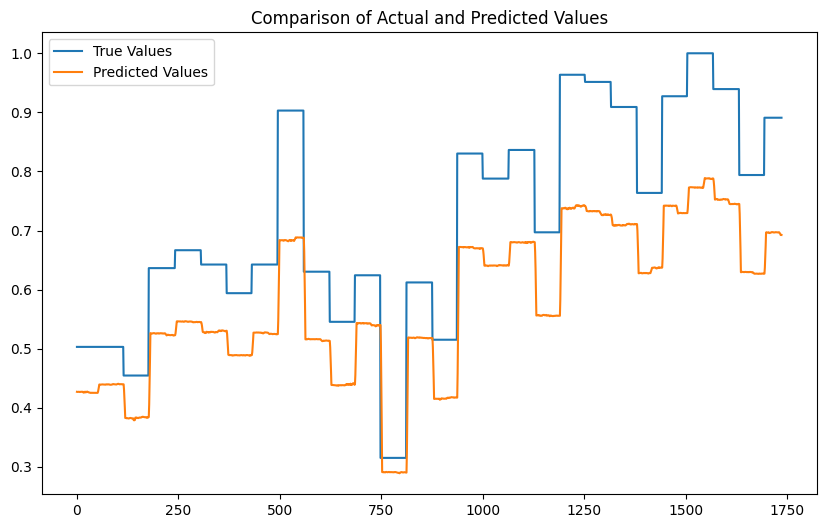

In [34]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [35]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.0144
Test Loss: 0.022611675783991814


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0287 - val_loss: 0.0411
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2300e-04 - val_loss: 0.0399
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0833e-04 - val_loss: 0.0399
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7233e-04 - val_loss: 0.0400
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3286e-04 - val_loss: 0.0405
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6560e-04 - val_loss: 0.0396
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6227e-04 - val_loss: 0.0397
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5329e-04 - val_loss: 0.0394
Epoch 9/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3040e-04 - val_loss: 0.0388
Epoch 10/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9415e-04 - val_loss: 0.0398
Epoch 11/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0138e-04 - val_loss: 0.0381
E

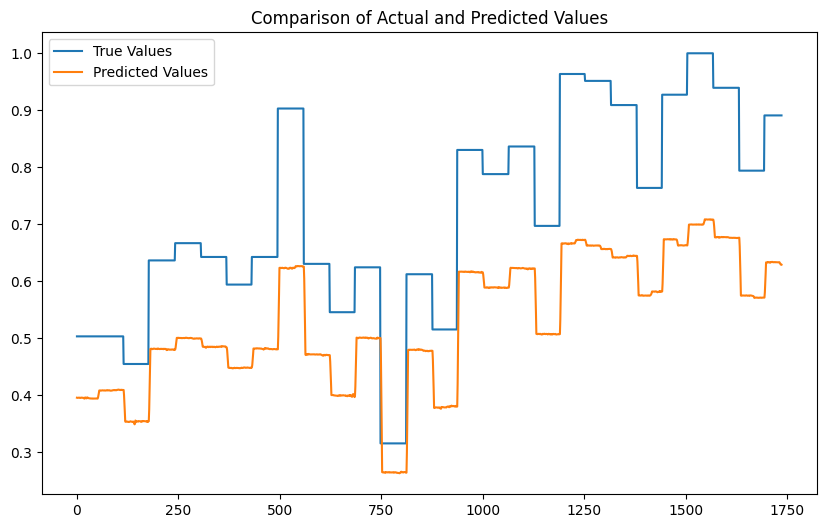

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0263
Test Loss: 0.040641769766807556


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Lambda
import tensorflow.keras.backend as K

# Define the RNN model with bias correction included
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(1),  # Output layer - initially outputs the raw predictions
    Lambda(lambda x: x + K.constant(0.5))  # Adding bias correction directly in the model
])

# Display model summary to verify its structure
model.summary()

# Compile the model using SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

# Assuming X_train and y_train are already defined and properly shaped
history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.2)

# Predicting and plotting results
import matplotlib.pyplot as plt

predicted_values = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


## Model Specific Preprocessing 

## Model Specific Tuning

## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

## RNN results (Franco)


# XGBoost (Hank)
## Why this model for this problem
## Model Architecture
## Model Specific Preprocessing 
## Model Specific Tuning
## Model Evaluation

## Fitted Model and Results
    - Report on hyper parameters
    - Report on fit quality
    - Ideas on improvement if the model was continued to be

# Support Vector Machines (Bhavesh)

## Why this model for this problem
Support Vector Machines (SVMs) offer a compelling approach for forecasting future firm earnings based on financial data due to their robustness in handling high-dimensional datasets and ability to capture complex relationships between features. In financial forecasting, where datasets often contain numerous predictors and intricate patterns, SVMs excel at identifying the optimal decision boundary that separates different market regimes or states, thereby enabling accurate prediction of earnings trends. Additionally, SVMs can effectively handle both linear and non-linear relationships through the use of appropriate kernel functions, making them versatile for capturing the nuanced dynamics of financial markets. Their ability to generalize well to unseen data further enhances their utility in this context, as it ensures reliable predictions even in the face of changing market conditions.

## Model Architecture
SVM aims to find the optimal hyperplane that separates data classes while maximizing margin. It utilizes support vectors and kernel functions to handle non-linear relationships efficiently. Regularization prevents overfitting, and the decision function assigns new data points to classes based on their position relative to the hyperplane.

In [56]:
from sklearn.svm import SVR

# Create a Support Vector Regressor
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svr.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)

We'd like to plot this data against the original test values to get a visual representation of how it performed.

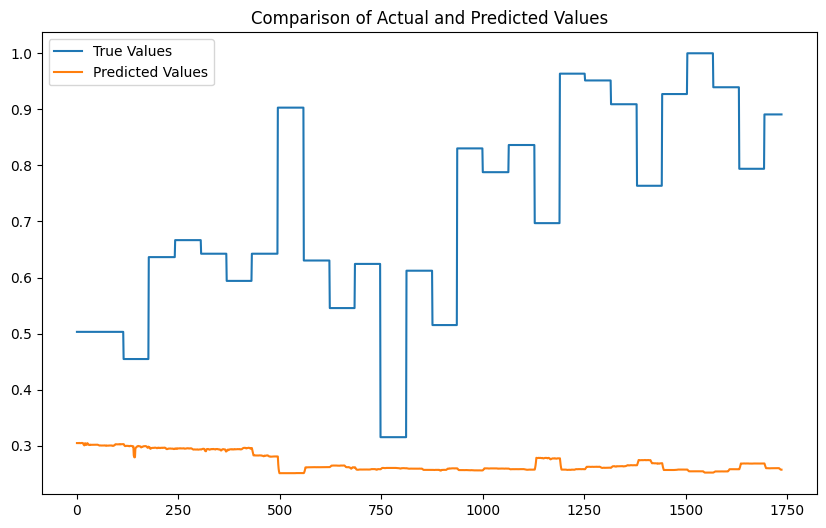

In [57]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
We would like to use the Mean squared Error to evaluate this model and better compare it to the other models.

In [58]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.23455574605030258


### Hypertuning Parameters
We'd like to make this model more robust and ensure that the parameters are well suited for this specific usecase. We will use GridSearchCV to hypertune the parameters inorder to get a better prediction

In [51]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'kernel': ['rbf', 'linear', 'poly']
}

# Create a Support Vector Regressor
svr = SVR()

# Create GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_reshaped, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

# Train the model with the best parameters
svr_best = SVR(**best_params)
svr_best.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)

Best parameters:  {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}


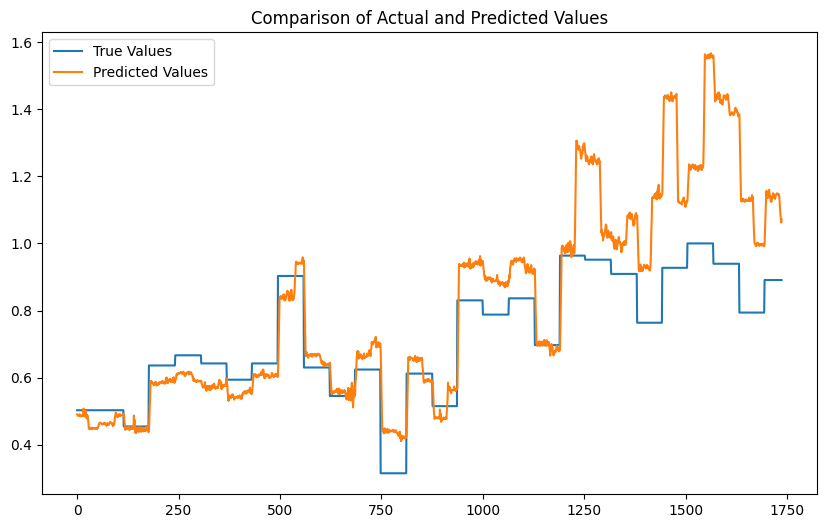

In [52]:
import matplotlib.pyplot as plt

# Predicting
predicted_values = svr_best.predict(X_test_reshaped)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set
y_pred = svr_best.predict(X_test_reshaped)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.03431552704503399


### SVM Result Explanation
The SVM branch with parameters {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'} likely performed well due to its choice of parameters tailored to the problem. A polynomial kernel might have effectively captured the non-linear relationships in the data, while a smaller regularization parameter (C) and epsilon might have helped in achieving a smoother fit with lesser error. Conversely, SVM with {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.2} exhibited higher Mean Squared Error (MSE), potentially due to overfitting or less suitable parameter choices for the data, particularly with the radial basis function kernel, which might have been sensitive to the given C and epsilon values. Overall the SVM performed well due to its ability to effectively handle complex relationships in the financial data and generalize well to unseen data.

# Vanila Neural Network (Bhavesh)

### Why this model for this problem
A Vanilla Neural Network (VNN) can effectively forecast firm earnings by leveraging its capacity to capture complex non-linear relationships present in financial data. Through hierarchical feature representations and non-linear mapping, VNNs adapt to historical data during training, enabling accurate predictions about future earnings. Techniques like regularization prevent overfitting, ensuring generalization to unseen data. With flexible architectures, VNNs can be tailored to the specific characteristics of the dataset, optimizing performance for the forecasting task at hand.

### What is the model archetecture
The model architecture utilizes a Vanilla Neural Network (VNN) implemented using TensorFlow's Keras API. It comprises three fully connected (Dense) layers. The input layer consists of 50 neurons with Rectified Linear Unit (ReLU) activation, followed by a dropout layer with a dropout rate of 0.2 to prevent overfitting. The second hidden layer also consists of 50 neurons with ReLU activation, followed by another dropout layer. The output layer consists of a single neuron, assuming a single output. The input shape is determined by the number of timesteps (n_steps) multiplied by the number of features in the dataset (n_features). The model structure is summarized using the `summary()` function to verify its configuration and parameter count.

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

n_steps = 4  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

# Define the vanilla neural network model
model = Sequential([
    Dense(50, activation='relu', input_shape=(n_steps * n_features,)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer - assumes a single output
])

# Display model summary to verify its structure
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 50)             │         1,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451 (17.39 KB)

 Trainable params: 4,451 (17.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 0.0078 
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 0.0012
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 7.4028e-04
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 6.2820e-04
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 5.6504e-04
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 5.0351e-04
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 3.9988e-04
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 4.2298e-04
Epoch 9/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 3.3444e-04
Epoch 10/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 4.0682e-04
Epoch 11/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 5.3049e-04
Epoch 12/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 3.5396e-04
Epoch 13/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 3.7692e-04
Epoch 14/200
218/218 ━━━━━━━━━━━━━━━━━━━━

### Why use SGD Optimizer
Using Stochastic Gradient Descent (SGD) optimizer for this Vanilla Neural Network (VNN) is advantageous due to its computational efficiency, scalability to large datasets, and flexibility in hyperparameter tuning. SGD introduces randomness, aiding generalization and preventing overfitting. It converges to global minima with appropriate tuning and offers interpretability, facilitating model development and debugging. Overall, SGD optimizes training efficiency and enhances the VNN's performance in forecasting firm earnings.

In [75]:

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the model
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')
model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test_reshaped)

Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 1.9652e-04
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 1.5944e-04
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 1.5680e-04
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1.7073e-04
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 1.8196e-04
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1.6397e-04
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 1.8301e-04
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 1.4823e-04
Epoch 9/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.9994e-04
Epoch 10/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 1.7054e-04
Epoch 11/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 1.6414e-04
Epoch 12/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 1.6054e-04
Epoch 13/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 1.4819e-04
Epoch 14/200
218/218 ━━━━━━━━━━━━━

We'd like to plot this data against the original test values to get a visual representation of how it performed.

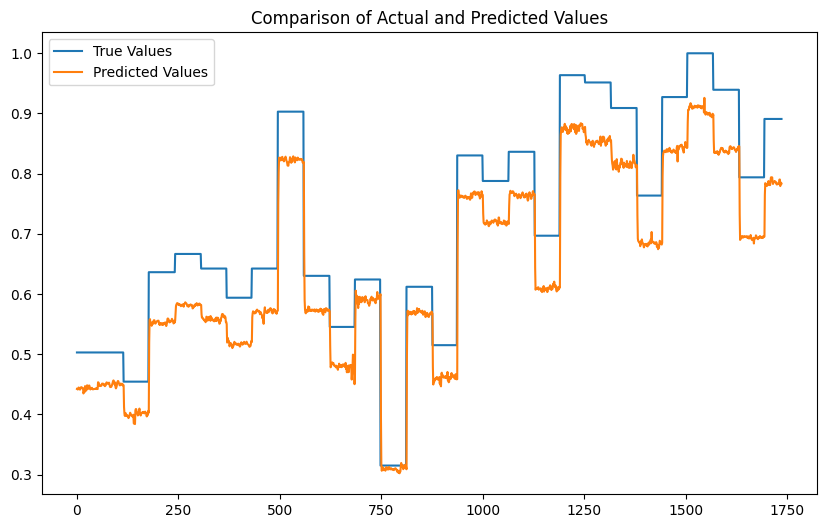

In [77]:
import matplotlib.pyplot as plt

# Predicting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

### Evaluating the model
We would like to use the Mean squared Error to evaluate this model and better compare it to the other models.

In [79]:
test_loss = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.0051
Test Loss: 0.0062643010169267654


### Hypertuning the parameters
We will perform hyperparameter tuning for the Vanilla Neural Network (VNN) where we explore different combinations of parameters such as the number of units in input and hidden layers, learning rate, and momentum. The Keras Tuner systematically searches these hyperparameters to minimize the mean squared error loss. This optimization process fine-tunes the VNN's architecture and training parameters, tailored specifically for forecasting firm earnings. By selecting the best configuration, the model's performance is optimized, leading to more accurate predictions.

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch

n_steps = 4  # This should match the number of timesteps you decided to use in your sequences
n_features = merged_df.shape[1]  # Number of features in your dataset

def build_model(hp):
    model = Sequential([
        Dense(hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(n_steps * n_features,)),
        Dropout(0.2),
        Dense(hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer - assumes a single output
    ])

    # Compile the model
    sgd_optimizer = SGD(
        learning_rate=hp.Float('learning_rate', min_value=0.01, max_value=0.1, step=0.01),
        momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    )
    model.compile(optimizer=sgd_optimizer, loss='mean_squared_error')

    return model

# Define the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # The number of different models to try
    executions_per_trial=3,  # The number of times to train each model. This is useful to reduce results variance
    directory='my_dir',  # The directory where the results are stored
    project_name='vnn'  # The name of the project. This will be a subdirectory in the directory
)

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Run the hyperparameter search
tuner.search(X_train_reshaped, y_train, epochs=200, validation_data=(X_test_reshaped, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Make predictions on the test set
y_pred = best_model.predict(X_test_reshaped)

Trial 5 Complete [00h 01m 33s]
val_loss: 0.001501474529504776

Best val_loss So Far: 0.00136038971443971
Total elapsed time: 00h 08m 59s
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Below we will plot and find the MSE for the tuned model and see how well it does.

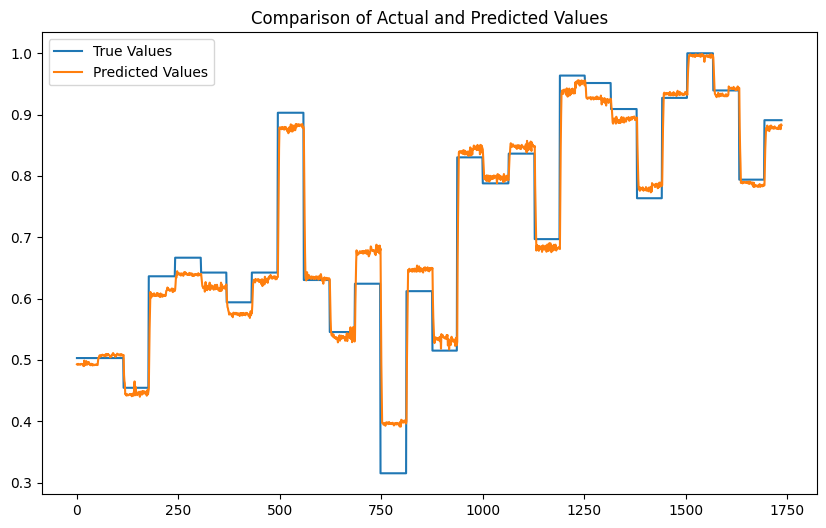

In [82]:
import matplotlib.pyplot as plt

# Predicting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.legend()
plt.show()

In [83]:
test_loss = best_model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.0011   
Test Loss: 0.0012310747988522053


### VNN Result Explanation 
The Vanilla Neural Network (VNN) used in this project is a feedforward neural network architecture comprising input, hidden, and output layers. In the initial model configuration, two hidden layers with 50 neurons each and ReLU activation functions are employed, along with dropout layers to mitigate overfitting. This architecture is well-suited for financial forecasting tasks due to its ability to capture complex non-linear relationships present in the data. The mean squared error (MSE) of 0.0062643010169267654 obtained from the initial model reflects its initial performance.

However, through hyperparameter tuning using techniques like Random Search, we fine-tune the model's parameters such as the number of neurons in the layers, learning rate, and momentum. This optimization process aims to identify the optimal configuration that minimizes the validation loss, resulting in improved model performance. As a result of hyperparameter tuning, the mean squared error decreases significantly to 0.0012310747988522053. This reduction in MSE signifies that the hypertuned model is better able to capture the underlying patterns in the financial data, leading to more accurate predictions of firm earnings.